<a href="https://colab.research.google.com/github/bi-horn/CNN_Medical_Image_Classification/blob/main/CNN_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
print(torchvision.__version__)

0.16.0+cu121


In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To train and validate our PyTorch models in Google Colab, you can follow these steps:

1. Load the dataset into a format that PyTorch can use, such as a torch.utils.data.Dataset.
2. Split the dataset into training and validation sets, for example using torch.utils.data.random_split().
3. Define a loss function, for example using torch.nn.CrossEntropyLoss().
4. Define an optimizer, for example using torch.optim.Adam().
5. Train the model for a specified number of epochs or until convergence.
6. Validate the model using validation split.
7. Save the trained model to disk using torch.save().

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, time, random, torch, warnings
from PIL import Image
import torch.nn as nn
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from torchvision.models.inception import InceptionOutputs
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split



#warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

Defining functions

In [94]:
#Data Preprocessing
def data_preprocess(data_path, sample_ratio):
  # Create data transforms
  data_transforms = transforms.Compose([
    #standard measures if you want to use e.g. ResNet18
    transforms.Resize((224, 224)), #Consistent Formatting: Ensure uniform size and tensor format for inputs
    transforms.RandomHorizontalFlip(), #Data Augmentation: Enhance dataset diversity with random transformations
    transforms.ToTensor(), #datset to 4D tensor (# of images, height, width, channels)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Standardization: Normalize pixel values for consistent convergence

  # Get dataset from folder and apply data transforms
  dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)


  # Get a sample of the data randomly
  num_samples = int(len(dataset) * sample_ratio)
  indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

  # Split the data into training, test, and validation sets
  train_size = int(0.7 * num_samples)
  test_size = int(0.2 * num_samples)
  val_size = num_samples - train_size - test_size

  train_indices = indices[ : train_size]
  test_indices = indices[train_size : train_size + test_size]
  val_indices = indices[train_size + test_size : ]


  # Create random training, test, and validation datasets

  samples = [torch.utils.data.sampler.SubsetRandomSampler(i) for i in [train_indices, test_indices, val_indices]]

  train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0], num_workers = 4, pin_memory = True)
  test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1], num_workers = 4, pin_memory = True)
  val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2], num_workers = 4, pin_memory = True)

  return dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices

In [131]:
def evaluate_model(model, dataloader, data_size, dtype, criterion, data_path, model_name):
  _loss, _pred, _true, _accuracy = 0.0, [], [], []
  model.eval()

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _loss += loss.item() * inputs.size(0) #Accumulate the loss for the current mini-batch, loss is scaled by the batch size to compute the total loss size
      _, predicted = torch.max(outputs.data, 1) #Compute the predicted class indices for each element in the mini-batch: find the indices of the maximum values along the second dimension of the output tensors
      _pred.extend(predicted.cpu().numpy()) #Append the predicted class indices to the _pred list
      _true.extend(labels.cpu().numpy()) #Append the actual class indices to the _true list

  _loss /= len(data_size) #Calculate the average loss by dividing the total loss by the size of the dataset
  _accuracy = accuracy_score(_true, _pred) #Compute the accuracy score by comparing the true labels with the predicted labels
  #The average='macro' parameter calculates the score for each class independently and then averages them
  _recall = recall_score(_true, _pred, average='macro') #measures the ability of the classifier to identify all relevant instances
  _precision = precision_score(_true, _pred, average='macro') #measures the ability of the classifier not to label as positive a sample that is negative
  _fscore = f1_score(_true, _pred, average='macro') # F1 score = harmonic mean of precision and recall

  print('{}: Accuracy: {:.4f} | Loss: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F-score: {:.4f}'.format(dtype, _accuracy, _loss, _recall, _precision, _fscore))
  print("")

  return _accuracy, _loss, _true, _pred

In [132]:

def train_model(model, criterion, optimizer, model_name, num_epochs):

  #Create tracking variables
  losses = []
  accuracies = []
  true = []
  pred = []
  v_accuracies = []
  v_losses = []

  #for loop through epochs
  for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0
    start_time = time.time() #set the timer

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar: #Progress Bar Initialization
      #Training Loop
      for inputs, labels in train_loader: #Iterates through the training dataset using the train_loader; each iteration processes a mini-batch of input data and their corresponding labels
        #Moves the input data and labels to the computing device (e.g., GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #Resets the gradients of the optimizer to zero
        outputs = model(inputs)
        #Prediction and Loss Calculation
        #Calculates the loss between the model predictions and the actual labels using the specified loss criterion
        #consider Inception Models in case you want to use e.g. ResNet18
        _, preds = torch.max(outputs.logits if isinstance(outputs, InceptionOutputs) else outputs, dim = 1) #logits = raw scores produced by the final layer of the Inception model before applying a softmax activation function
        loss = criterion(outputs.logits if isinstance(outputs, InceptionOutputs) else outputs, labels)

        #Backpropagation and Optimization
        loss.backward()
        optimizer.step()
        #Metrics Calculation
        train_loss = loss.item() * inputs.size(0) #Computes the loss for the current mini-batch (train_loss) and accumulates it over all batches
        train_accuracy += torch.sum(preds == labels.data) #Updates the training accuracy (train_accuracy) by comparing the predicted labels with the actual labels
        #Data Aggregation
        pred.extend(preds.cpu().numpy()) #Extends lists (pred and true) with the predictions and actual labels for the current mini-batch, respectively.
        true.extend(labels.cpu().numpy())

        #print results
        pbar.set_postfix({'Accuracy': train_accuracy.item()/len(train_indices), 'Loss': train_loss/len(train_indices)*100, 'Precision': precision_score(true, pred, average='macro'), 'Recall': recall_score(true, pred, average='macro'), 'F1 Score': f1_score(true, pred, average = 'macro')})
        pbar.update()

    #evaluate model for validation dataset
    val_accuracy, val_loss, val_true, val_pred = evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, model_name)

    v_accuracies.append(val_accuracy)
    v_losses.append(val_loss)
    losses.append(train_loss/len(train_indices))
    accuracies.append(train_accuracy.item()/len(train_indices))

  save_metrics(losses, accuracies, model_name)
  return losses, accuracies, v_accuracies, v_losses

Starting with model

In [116]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNetwork(nn.Module):


    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)  # Input channels: 3, Output channels: 6, Kernel size: 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, 1)  # Input channels: 6, Output channels: 16, Kernel size: 5x5
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # Input size: 16*53*53, Output size: 120
        #53 * 53 because the input image size is 224x224 pixels, and each max-pooling operation with a 2x2 kernel and stride 2 reduces the dimensions by a factor of 2. After passing through two max-pooling layers, the height and width dimensions are reduced to approximately one-fourth of the original size, resulting in a feature map size of approximately 53x53.
        self.fc2 = nn.Linear(120, 84)  # Input size: 120, Output size: 84
        self.fc3 = nn.Linear(84, 2)  # Input size: 84, Output size: 2 (2 classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  # Max pooling with 2x2 kernel and stride 2; dimensions of the feature map are reduced by a factor of 2 in both height and width
        # Second convolutional layer
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)  # Max pooling with 2x2 kernel and stride 2

        # Flatten the feature map
        X = X.view(-1, 16 * 53 * 53)  # Calculate the new size based on the dimensions of the feature map after the second convolutional layer

        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


In [99]:
#create an instance

#torch.manual_seed(41)
#model = ConvolutionalNetwork()
#model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [117]:
data_path = '/content/drive/My Drive/Simple_Chest_XRay/'

sample_ratio = 0.4
batch_size = 50
num_epochs = 10

In [136]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [137]:
#load training, test and validation datasets and preprocess the images

dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

Dataset ImageFolder
    Number of datapoints: 1401
    Root location: /content/drive/My Drive/Simple_Chest_XRay/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


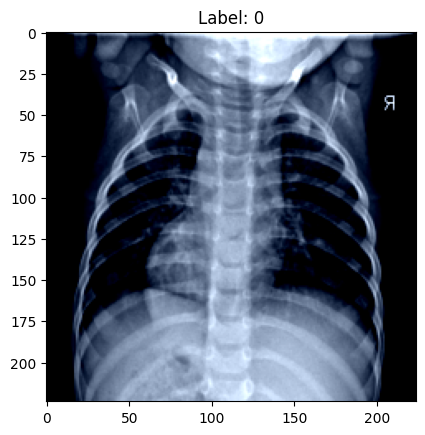

In [107]:
print(dataset)

#Grab 1 image
# Get one batch of data from the train loader
for images, labels in train_loader:
    break  # Exit the loop after the first batch

# Convert Tensor to numpy array
image = images[0].numpy()
label = labels[0].item()

# Denormalize the image (if normalization was applied)
# Use the inverse of the normalization transform, e.g. if you used transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# you can denormalize by multiplying by 0.5 and then adding 0.5
image = image * 0.485 + 0.229

# Display the image
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'Label: {label}')
plt.show()

In [135]:
#either use predefined model e.g. ResNet18 (Version 1) or self-defined simpler model (Version 2)

#Version 1:
# Define the ResNet18 model and set Pretraining to False to train model from scratch

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes)) #replaces the fully connected layer (model.fc) with a new one that has the output size matching the number of classes in the dataset
#print(len(dataset.classes)) #= 2 NORMAL or PNEUMONIA
model.to(device)

# Define loss function a  s CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "ResNet18", num_epochs)




Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Epoch 1/10: 100%|██████████| 8/8 [00:13<00:00,  1.64s/batch, Accuracy=0.786, Loss=4.96, Precision=0.786, Recall=0.783, F1 Score=0.784]


VALIDATION: Accuracy: 0.5357 | Loss: 1.2302 | Recall: 0.5000 | Precision: 0.2679 | F-score: 0.3488



Epoch 2/10:   0%|          | 0/8 [00:03<?, ?batch/s]


KeyboardInterrupt: 

In [138]:

#Version 2:
model = ConvolutionalNetwork()
model.to(device)

# Define loss function a  s CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Simple_model", num_epochs)

Epoch 1/10: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch, Accuracy=0.648, Loss=6.2, Precision=0.705, Recall=0.663, F1 Score=0.633]


VALIDATION: Accuracy: 0.8393 | Loss: 0.5591 | Recall: 0.8372 | Precision: 0.8394 | F-score: 0.8380



Epoch 2/10: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch, Accuracy=0.844, Loss=4.78, Precision=0.767, Recall=0.754, F1 Score=0.744]


VALIDATION: Accuracy: 0.8750 | Loss: 0.4262 | Recall: 0.8705 | Precision: 0.8808 | F-score: 0.8730



Epoch 3/10: 100%|██████████| 8/8 [00:10<00:00,  1.27s/batch, Accuracy=0.916, Loss=3.33, Precision=0.811, Recall=0.808, F1 Score=0.803]


VALIDATION: Accuracy: 0.8393 | Loss: 0.3550 | Recall: 0.8321 | Precision: 0.8524 | F-score: 0.8350



Epoch 4/10: 100%|██████████| 8/8 [00:08<00:00,  1.05s/batch, Accuracy=0.918, Loss=1.63, Precision=0.836, Recall=0.835, F1 Score=0.832]


VALIDATION: Accuracy: 0.8393 | Loss: 0.3218 | Recall: 0.8372 | Precision: 0.8394 | F-score: 0.8380



Epoch 5/10: 100%|██████████| 8/8 [00:08<00:00,  1.01s/batch, Accuracy=0.936, Loss=1.85, Precision=0.855, Recall=0.855, F1 Score=0.853]


VALIDATION: Accuracy: 0.8393 | Loss: 0.3007 | Recall: 0.8372 | Precision: 0.8394 | F-score: 0.8380



Epoch 6/10: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch, Accuracy=0.936, Loss=1.68, Precision=0.868, Recall=0.869, F1 Score=0.866]


VALIDATION: Accuracy: 0.8393 | Loss: 0.3237 | Recall: 0.8449 | Precision: 0.8471 | F-score: 0.8392



Epoch 7/10: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch, Accuracy=0.972, Loss=0.502, Precision=0.882, Recall=0.884, F1 Score=0.882]


VALIDATION: Accuracy: 0.8750 | Loss: 0.2874 | Recall: 0.8756 | Precision: 0.8742 | F-score: 0.8746



Epoch 8/10: 100%|██████████| 8/8 [00:09<00:00,  1.22s/batch, Accuracy=0.972, Loss=1.83, Precision=0.893, Recall=0.895, F1 Score=0.893]


VALIDATION: Accuracy: 0.8750 | Loss: 0.3081 | Recall: 0.8808 | Precision: 0.8832 | F-score: 0.8750



Epoch 9/10: 100%|██████████| 8/8 [00:08<00:00,  1.06s/batch, Accuracy=0.964, Loss=1.4, Precision=0.901, Recall=0.902, F1 Score=0.901]


VALIDATION: Accuracy: 0.8571 | Loss: 0.3245 | Recall: 0.8590 | Precision: 0.8571 | F-score: 0.8570



Epoch 10/10: 100%|██████████| 8/8 [00:08<00:00,  1.02s/batch, Accuracy=0.974, Loss=1.65, Precision=0.908, Recall=0.91, F1 Score=0.908]


VALIDATION: Accuracy: 0.8393 | Loss: 0.3015 | Recall: 0.8372 | Precision: 0.8394 | F-score: 0.8380



In [139]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [140]:
#torch.save(model.state_dict(), "{}resnet18.pth".format(data_path))
torch.save(model.state_dict(), "{}simple_model.pth".format(data_path))

In [15]:
# Load the saved model parameters
model.load_state_dict(torch.load("{}resnet18.pth".format(data_path)))

<All keys matched successfully>

In [141]:
def plot_model_curves(losses, accuracies, v_accuracies, v_losses):
  #Plotting the Loss and Accuracy Curves
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(losses, label = "Training Loss")
  ax1.plot(v_losses, label = "Validation Loss")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training and Validation Loss Curve')
  ax1.legend()

  ax2.plot(accuracies, label = "Training Accuracy")
  ax2.plot(v_accuracies, label = "Validation Accuracy")
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Training and Validation Accuracy Curve')
  ax2.legend()

  plt.show()

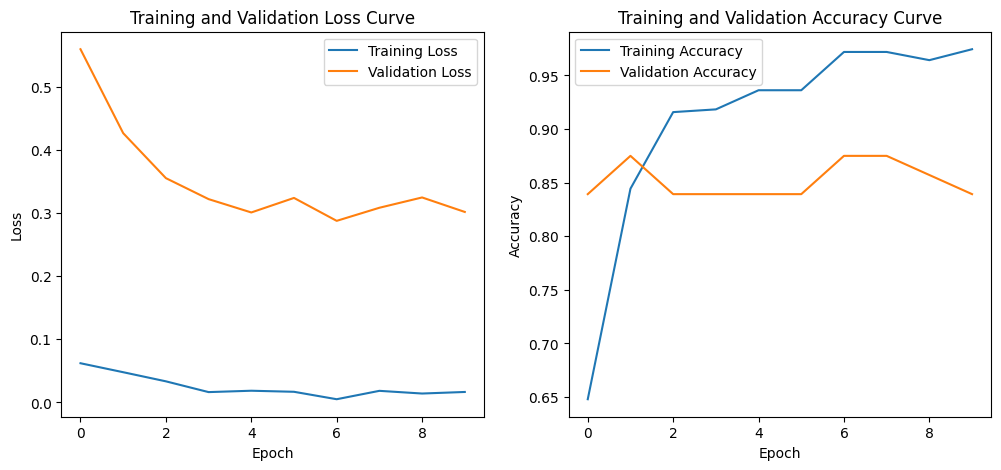

In [142]:
#Plot the Model Accuracy and Loss on Training and Validation Sets
plot_model_curves(losses, accuracies, v_accuracies, v_losses)

In [169]:
#Evaluate Model on Test Set
def plot_confusion_mat(_true, _pred, model_name, dataloader, dtype):
    # calculate confusion matrix
    cm = confusion_matrix(_true, _pred)

    plt.figure(figsize=(10, 10))

    #Create ConfusionMatrixDisplay object with labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("{}_{}_CONFUSION_MATRIX".format(model_name, dtype))

TEST: Accuracy: 0.9375 | Loss: 0.1617 | Recall: 0.9340 | Precision: 0.9432 | F-score: 0.9366



<Figure size 1000x1000 with 0 Axes>

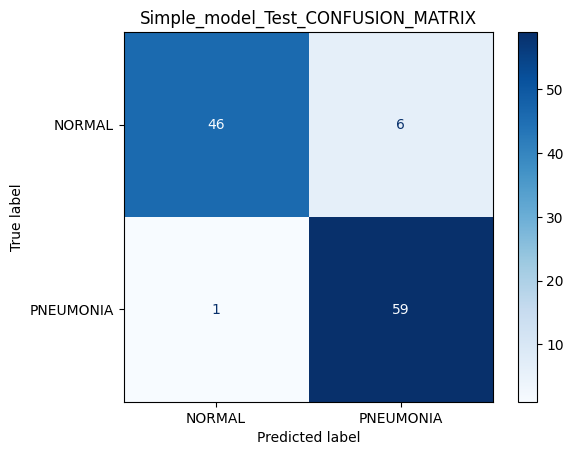

In [170]:
test_accuracy, test_loss, test_true, test_pred = evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Simple_model")

plot_confusion_mat(test_true, test_pred, "Simple_model", test_loader, "Test")

In [171]:
#Hyperparameter tuning for Simple Model

learning_rate = [0.005, 0.0001, 0.0005, 0.00001]

for i in learning_rate:
  model = ConvolutionalNetwork()
  model.to(device)

  print("Training Model {} with Learning Rate = {}, Batch Size = {}, Number of Epochs = {}".format(learning_rate.index(i)+1, i, batch_size, num_epochs))
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = i)

  losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Simple_Model", num_epochs)
  #Save Model
  torch.save(model.state_dict(), "{}{}_Simple_model.pth". format(data_path, i))
  #Plotting the Loss and Accuracy Curves
  plot_model_curves(losses, accuracies, v_accuracies, v_losses)
  #Evaluate Model on Test Set
  evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Simple_Model")


Training Model 1 with Learning Rate = 0.005, Batch Size = 50, Number of Epochs = 10


Epoch 1/10: 100%|██████████| 8/8 [00:10<00:00,  1.35s/batch, Accuracy=0.508, Loss=7.76, Precision=0.514, Recall=0.513, F1 Score=0.506]


VALIDATION: Accuracy: 0.4286 | Loss: 0.7044 | Recall: 0.4026 | Precision: 0.3021 | F-score: 0.3243



Epoch 2/10:   0%|          | 0/8 [00:03<?, ?batch/s]


KeyboardInterrupt: 